In [1]:
dataset_base_path = "/media/jfallmann/T9/University/master_thesis/dataset"

tables_path = f"{dataset_base_path}/tables"
mri_bids_path = f"{dataset_base_path}/mri/bids"


In [2]:
subjects_in_order = []

with open(f'{dataset_base_path}/subjects.txt') as subjects_file:
    for line in subjects_file:
        subjects_in_order.append(line.strip())

In [3]:
def clean_id(id: str) -> str:
    return id.replace("_", "").replace(".", "").replace("-", "").lower()

In [4]:
import glob
import re
from datetime import datetime
bids_files = glob.glob(f"{mri_bids_path}/**/*.nii", recursive=True)

session_dates = {}

for file in bids_files:
    subject_id = re.search(r'sub-(\w+)', file).group(1)
    session_id = re.search(r'ses-(\w+)', file).group(1)

    session_dates[subject_id] = datetime.strptime(session_id[:8], '%Y%m%d')

In [5]:
class DemographicInformation:
    def __init__(self, subject_id):
        self.subject_id = subject_id
        self.age = 0
        self.gender = 0
        self.diagnosis = 0
        self.mmse = 0
        self.diagnosis_date = None
        self.mmse_date = None

    def add_age(self, age):
        self.age = age

    def __str__(self):
        return f"Subject {self.subject_id} has age {self.age} and gender {self.gender}, diagnosis {self.diagnosis}, mmse {self.mmse}"

In [6]:
import pandas as pd

tabular_data = pd.read_csv(f"{tables_path}/Cohort_21_My_Table_06Jan2025.csv")
selected_subjects = tabular_data[tabular_data['subject_id'].map(lambda x: clean_id(x)).isin(subjects_in_order)]
selected_subjects

,subject_id,visit,BCPREDX,MMSCORE,APCOLLECT,DIAGNOSIS,PTGENDER,subject_age,subject_date
0,011_S_0021,m06,1.0,29.0,NaN,1.0,2,72.65,2005-09-28
1,011_S_0023,m06,1.0,28.0,NaN,1.0,1,71.79,2005-10-18
2,131_S_0123,m06,1.0,30.0,NaN,1.0,1,73.34,2006-01-05
3,073_S_0089,m06,1.0,30.0,NaN,1.0,1,65.13,2005-01-18
4,011_S_0021,m12,1.0,30.0,NaN,1.0,2,72.65,2005-09-28
...,...,...,...,...,...,...,...,...,...
4628,941_S_1195,m192,NaN,NaN,NaN,1.0,1,76.97,2007-01-22
4629,941_S_4292,m126,NaN,NaN,NaN,1.0,1,70.95,2011-10-14
4630,137_S_4520,m120,NaN,NaN,NaN,1.0,1,67.92,2012-01-31
4631,011_S_4278,m156,NaN,NaN,NaN,3.0,1,75.07,2011-09-29


In [7]:
# get age of subjects
demographic_information_for_subjects = []
processed_subjects = set()
for index, row in selected_subjects.iterrows():
    subject_id = clean_id(row['subject_id'])
    if subject_id in processed_subjects:
        continue
    processed_subjects.add(subject_id)
    age = row['subject_age']
    gender = row['PTGENDER']

    age_diff = session_dates[subject_id] - datetime.strptime(row['subject_date'], '%Y-%m-%d')
    age = age + age_diff.days / 365.25
    demographic_information = DemographicInformation(subject_id)
    demographic_information.age = age
    demographic_information.gender = gender
    demographic_information_for_subjects.append(demographic_information)

In [8]:
diagnosis_table = pd.read_csv(f"{tables_path}/Cohort_21_DXSUM_06Jan2025.csv")
diagnosis_table

,PHASE,PTID,RID,VISCODE,VISCODE2,EXAMDATE,DIAGNOSIS,DXNORM,DXNODEP,DXMCI,...,DXODES,DXCONFID,ID,SITEID,USERDATE,USERDATE2,DD_CRF_VERSION_LABEL,LANGUAGE_CODE,HAS_QC_ERROR,update_stamp
0,ADNI1,011_S_0021,21,bl,bl,2005-11-01,1.0,1.0,-4.0,-4.0,...,-4.0,4.0,20,107,2005-11-02,NaN,NaN,NaN,NaN,2005-11-02 00:00:00.0
1,ADNI1,011_S_0023,23,bl,bl,2005-11-08,1.0,1.0,-4.0,-4.0,...,-4.0,4.0,68,107,2006-01-05,NaN,NaN,NaN,NaN,2006-01-05 00:00:00.0
2,ADNI1,131_S_0123,123,bl,bl,2006-02-14,1.0,1.0,-4.0,-4.0,...,-4.0,4.0,144,118,2006-02-14,NaN,NaN,NaN,NaN,2006-02-14 00:00:00.0
3,ADNI1,073_S_0089,89,bl,bl,2006-01-31,1.0,1.0,-4.0,-4.0,...,-4.0,4.0,190,36,2006-03-01,NaN,NaN,NaN,NaN,2006-03-01 00:00:00.0
4,ADNI1,011_S_0021,21,m06,m06,2006-04-24,1.0,1.0,-4.0,-4.0,...,-4.0,4.0,354,107,2006-04-27,NaN,NaN,NaN,NaN,2006-04-27 00:00:00.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4511,ADNI4,023_S_4448,4448,4_m12,m156,2024-11-21,1.0,NaN,NaN,NaN,...,NaN,NaN,51087,23,2024-11-21,2024-11-21,v1,e,0.0,2024-11-22 00:42:08.0
4512,ADNI4,003_S_4872,4872,4_init,m144,2024-11-15,1.0,NaN,NaN,NaN,...,NaN,NaN,51220,3,2024-11-21,2024-11-21,v1,e,0.0,2024-11-22 00:42:08.0
4513,ADNI4,123_S_4127,4127,4_init,m156,2024-10-15,2.0,NaN,NaN,NaN,...,NaN,NaN,53976,123,2024-12-06,2024-12-06,v1,e,0.0,2024-12-07 00:35:49.0
4514,ADNI4,035_S_4785,4785,4_init,m138,2024-11-18,NaN,NaN,NaN,NaN,...,NaN,NaN,54230,35,2024-12-06,2024-12-06,v1,e,1.0,2024-12-07 00:35:49.0


In [9]:
# does the diagnosis table contain any nan values?
diagnosis_table.isna().sum()

PHASE                      0
PTID                       0
RID                        0
VISCODE                    0
VISCODE2                   6
EXAMDATE                  17
DIAGNOSIS                  8
DXNORM                  4397
DXNODEP                 4397
DXMCI                   4397
DXMDES                   445
DXMPTR1                 2249
DXMPTR2                 2255
DXMPTR3                 2250
DXMPTR4                 2250
DXMPTR5                 2250
DXMPTR6                 2250
DXMDUE                  2227
DXMOTHET                 677
DXDSEV                  3671
DXDDUE                  3789
DXAD                    4397
DXAPP                   3696
DXAPROB                 4397
DXAPOSS                  702
DXPARK                    28
DXPDES                  4397
DXPCOG                  4397
DXPATYP                 4397
DXDEP                    302
DXOTHDEM                4397
DXODES                  4380
DXCONFID                4397
ID                         0
SITEID        

In [10]:
# convert date to datetime
diagnosis_table['EXAMDATE'] = pd.to_datetime(diagnosis_table['EXAMDATE'], format='%Y-%m-%d')

# ignore all rows where the diagnosis is nan
diagnosis_table = diagnosis_table[diagnosis_table['DIAGNOSIS'].notna()]

# ignore all rows where the exam date is nan
diagnosis_table = diagnosis_table[diagnosis_table['EXAMDATE'].notna()]

# for each subject, get the diagnosis where the date is closest to the session date
for demographic_info in demographic_information_for_subjects:
    subject_id = demographic_info.subject_id
    diagnosis = diagnosis_table[diagnosis_table['PTID'].map(lambda x: clean_id(x)) == subject_id]
    if diagnosis.empty:
        print(f"Subject {subject_id} has no diagnosis")
        continue
    # remove NA values

    closest_date = diagnosis.iloc[(diagnosis['EXAMDATE'] - session_dates[subject_id]).abs().argsort()[:1]]
    demographic_info.diagnosis = closest_date['DIAGNOSIS'].values[0]
    demographic_info.diagnosis_date = closest_date['EXAMDATE'].values[0]

In [11]:
print(demographic_information_for_subjects[0])
print(demographic_information_for_subjects[0].diagnosis_date)

Subject 011s0021 has age 79.66711156741958 and gender 2, diagnosis 1.0, mmse 0
2012-10-11T00:00:00.000000000


In [12]:
mmse_table = pd.read_csv(f"{tables_path}/Cohort_21_MMSE_06Jan2025.csv")
mmse_table

,PHASE,PTID,RID,VISCODE,VISCODE2,VISDATE,DONE,NDREASON,SOURCE,MMDATE,...,MMDRAW,MMSCORE,ID,SITEID,USERDATE,USERDATE2,DD_CRF_VERSION_LABEL,LANGUAGE_CODE,HAS_QC_ERROR,update_stamp
0,ADNI1,011_S_0021,21,sc,sc,2005-09-28,NaN,NaN,NaN,1.0,...,1.0,30.0,52,107,2005-09-29,NaN,NaN,NaN,NaN,2005-09-29 00:00:00.0
1,ADNI1,011_S_0023,23,sc,sc,2005-10-18,NaN,NaN,NaN,1.0,...,1.0,26.0,82,107,2005-10-19,NaN,NaN,NaN,NaN,2024-08-22 07:18:34.0
2,ADNI1,131_S_0123,123,sc,sc,2006-01-05,NaN,NaN,NaN,1.0,...,1.0,30.0,214,118,2006-01-10,NaN,NaN,NaN,NaN,2006-01-10 00:00:00.0
3,ADNI1,073_S_0089,89,sc,sc,2006-01-18,NaN,NaN,NaN,1.0,...,1.0,30.0,262,36,2006-01-22,NaN,NaN,NaN,NaN,2006-01-22 00:00:00.0
4,ADNI1,137_S_0301,301,sc,sc,2006-02-20,NaN,NaN,NaN,1.0,...,1.0,28.0,494,124,2006-03-07,NaN,NaN,NaN,NaN,2024-08-22 07:18:34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3949,ADNI4,007_S_2394,2394,4_m12,m162,2024-11-06,1.0,NaN,1.0,0.0,...,1.0,29.0,47603,7,2024-11-08,2024-11-08,v1,e,0.0,2024-11-09 00:42:48.0
3950,ADNI4,009_S_0751,751,4_init,m216,2024-09-27,1.0,NaN,1.0,1.0,...,1.0,29.0,48423,9,2024-11-12,2024-11-12,v1,e,0.0,2024-11-13 00:42:38.0
3951,ADNI4,035_S_4785,4785,4_init,m138,2024-12-03,1.0,NaN,1.0,0.0,...,1.0,27.0,54333,35,2024-12-09,2024-12-09,v1,e,0.0,2024-12-10 00:38:38.0
3952,ADNI4,003_S_4350,4350,4_init,m156,2024-12-10,1.0,NaN,1.0,1.0,...,1.0,29.0,55622,3,2024-12-13,2024-12-13,v1,e,0.0,2024-12-13 00:40:47.0


In [13]:
# does the mmse table contain any nan values?
mmse_table.isna().sum()

PHASE                      0
PTID                       0
RID                        0
VISCODE                    0
VISCODE2                   7
VISDATE                    8
DONE                    3228
NDREASON                3929
SOURCE                  3742
MMDATE                    31
MMYEAR                    31
MMMONTH                   31
MMDAY                     31
MMSEASON                  31
MMHOSPIT                  31
MMFLOOR                   31
MMCITY                    31
MMAREA                    31
MMSTATE                   31
WORDLIST                 309
WORD1                     33
WORD2                     33
WORD3                     33
MMTRIALS                 732
MMD                      735
MML                      735
MMR                      735
MMO                      735
MMW                      735
MMLTR1                  3256
MMLTR2                  3256
MMLTR3                  3258
MMLTR4                  3261
MMLTR5                  3283
MMLTR6        

In [14]:
# convert date to datetime
mmse_table['VISDATE'] = pd.to_datetime(mmse_table['VISDATE'], format='%Y-%m-%d')

# ignore all rows where the diagnosis is nan
mmse_table = mmse_table[mmse_table['MMSCORE'].notna()]

# ignore all rows where the exam date is nan
mmse_table = mmse_table[mmse_table['VISDATE'].notna()]

# for each subject, get the diagnosis where the date is closest to the session date
for demographic_info in demographic_information_for_subjects:
    subject_id = demographic_info.subject_id
    mmse = mmse_table[mmse_table['PTID'].map(lambda x: clean_id(x)) == subject_id]
    if mmse.empty:
        print(f"Subject {subject_id} has no MMSE")
        continue
    # remove NA values

    closest_date = mmse.iloc[(mmse['VISDATE'] - session_dates[subject_id]).abs().argsort()[:1]]
    demographic_info.mmse = closest_date['MMSCORE'].values[0]
    demographic_info.mmse_date = closest_date['VISDATE'].values[0]

In [15]:
print(demographic_information_for_subjects[0])
print(demographic_information_for_subjects[0].mmse_date)

Subject 011s0021 has age 79.66711156741958 and gender 2, diagnosis 1.0, mmse 28.0
2012-10-03T00:00:00.000000000


In [16]:
# diagnosis distribution
diagnosis_distribution = {}
for demographic_info in demographic_information_for_subjects:
    diagnosis = demographic_info.diagnosis
    if diagnosis not in diagnosis_distribution:
        diagnosis_distribution[diagnosis] = 0
    diagnosis_distribution[diagnosis] += 1

diagnosis_distribution


{1.0: 135, 2.0: 219, 3.0: 55}

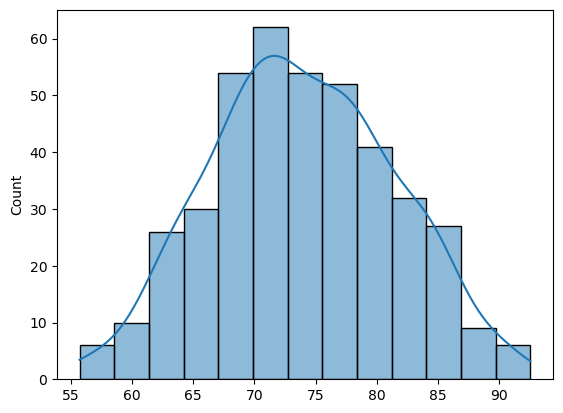

In [18]:
# distribution of age
import matplotlib.pyplot as plt
import seaborn as sns

ages = [demographic_info.age for demographic_info in demographic_information_for_subjects]
sns.histplot(ages, kde=True)
# set x-axis label
plt.xlabel("Age")
plt.show()


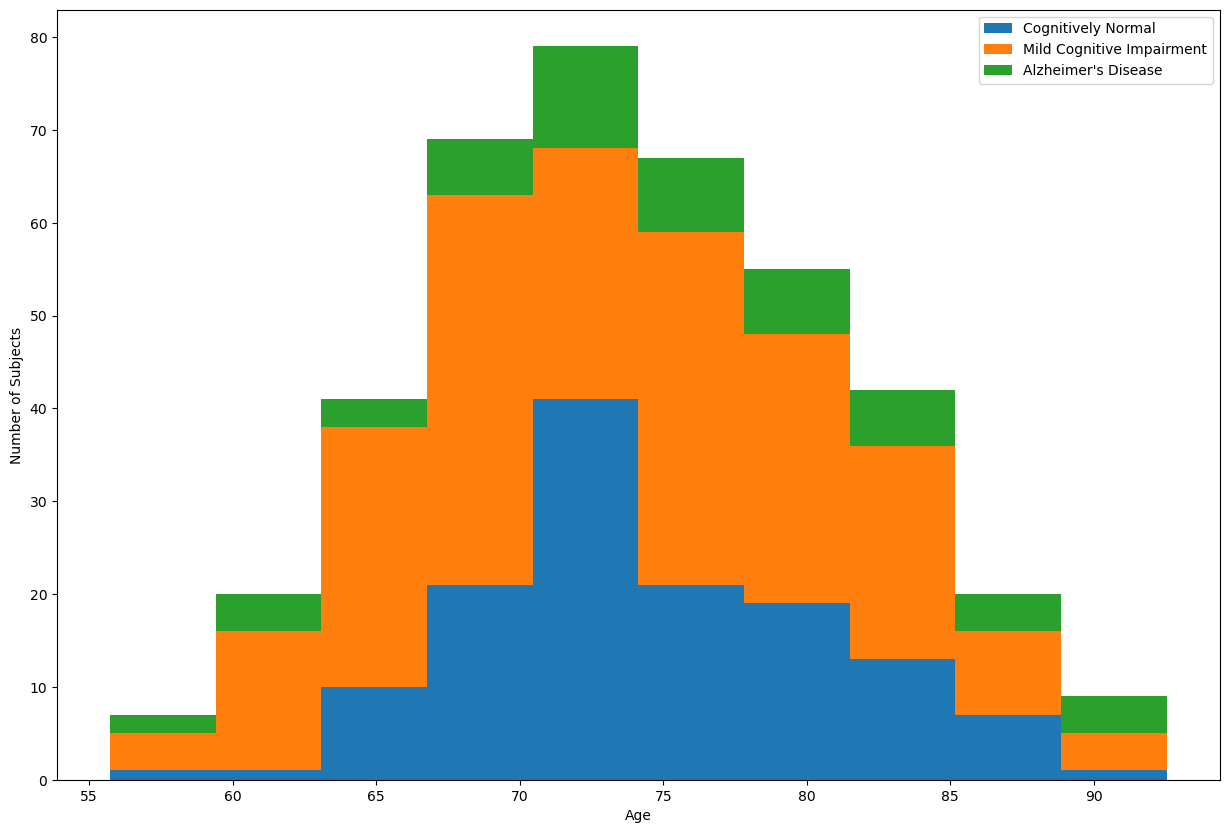

In [27]:
# distribution of age stacked bar chart by diagnosis
diagnosis_ages = {}
for demographic_info in demographic_information_for_subjects:
    diagnosis = demographic_info.diagnosis
    age = demographic_info.age
    if diagnosis not in diagnosis_ages:
        diagnosis_ages[diagnosis] = []
    diagnosis_ages[diagnosis].append(age)

fig, ax = plt.subplots(figsize=(15, 10))
diagnosis_labels = ["Cognitively Normal", "Mild Cognitive Impairment", "Alzheimer's Disease"]
ax.hist(diagnosis_ages.values(), bins=10, stacked=True, label=diagnosis_labels)
ax.set_xlabel("Age")
ax.set_ylabel("Number of Subjects")
ax.legend()
plt.show()

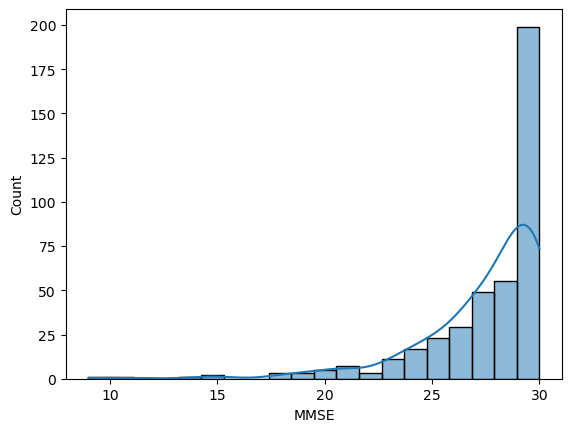

In [19]:
# distribution of mmse
mmse = [demographic_info.mmse for demographic_info in demographic_information_for_subjects]
sns.histplot(mmse, kde=True)
# set x-axis label
plt.xlabel("MMSE")
plt.show()

In [28]:
# distribution of gender

count_male = 0
count_female = 0

for demographic_info in demographic_information_for_subjects:
    if demographic_info.gender == 1:
        count_male += 1
    elif demographic_info.gender == 2:
        count_female += 1


print(f"Percentage male: {count_male/len(demographic_information_for_subjects) * 100}")
print(f"Percentage female: {count_female / len(demographic_information_for_subjects) * 100}")

Percentage male: 56.96821515892421
Percentage female: 43.03178484107579


In [127]:
# create a numpy array with the demographic information gender, age in order of subjects_in_order
import numpy as np
demographic_data = np.zeros((len(subjects_in_order), 3))

min_age = min(demographic_information_for_subjects, key=lambda x: x.age).age
max_age = max(demographic_information_for_subjects, key=lambda x: x.age).age

for index, subject_id in enumerate(subjects_in_order):
    demographic_info = next((x for x in demographic_information_for_subjects if x.subject_id == subject_id), None)
    if demographic_info is not None:
        demographic_data[index, 0] = (demographic_info.age - min_age) / (max_age - min_age)
        demographic_data[index, 1] = 1 if demographic_info.gender == 1 else 0
        demographic_data[index, 2] = 1 if demographic_info.gender == 2 else 0


In [128]:
demographic_data

array([[0.47943872, 0.        , 1.        ],
       [0.51545446, 0.        , 1.        ],
       [0.71142796, 1.        , 0.        ],
       ...,
       [0.67424034, 1.        , 0.        ],
       [0.33526478, 1.        , 0.        ],
       [0.41075242, 0.        , 1.        ]])

In [129]:
np.save(f"{tables_path}/demographic_data.npy", demographic_data)

In [130]:
# create a numpy array with the diagnosis and mmse in order of subjects_in_order
diagnosis_data = np.zeros((len(subjects_in_order), 2))

min_mmse = min(demographic_information_for_subjects, key=lambda x: x.mmse).mmse
max_mmse = max(demographic_information_for_subjects, key=lambda x: x.mmse).mmse

for index, subject_id in enumerate(subjects_in_order):
    demographic_info = next((x for x in demographic_information_for_subjects if x.subject_id == subject_id), None)
    if demographic_info is not None:
        diagnosis_data[index, 0] = demographic_info.diagnosis
        diagnosis_data[index, 1] = (demographic_info.mmse - min_mmse) / (max_mmse - min_mmse)


In [131]:
diagnosis_data

array([[1.        , 0.95238095],
       [2.        , 0.76190476],
       [1.        , 0.95238095],
       [2.        , 0.66666667],
       [1.        , 0.9047619 ],
       [1.        , 0.76190476],
       [2.        , 0.76190476],
       [2.        , 0.76190476],
       [3.        , 0.57142857],
       [2.        , 0.85714286],
       [3.        , 0.80952381],
       [1.        , 0.95238095],
       [2.        , 0.9047619 ],
       [2.        , 0.95238095],
       [2.        , 0.71428571],
       [1.        , 0.9047619 ],
       [1.        , 0.95238095],
       [1.        , 0.95238095],
       [3.        , 0.47619048],
       [3.        , 0.76190476],
       [3.        , 0.61904762],
       [1.        , 1.        ],
       [1.        , 0.95238095],
       [2.        , 0.85714286],
       [2.        , 0.80952381],
       [2.        , 0.9047619 ],
       [1.        , 0.95238095],
       [2.        , 0.85714286],
       [2.        , 0.85714286],
       [1.        , 0.95238095],
       [1.

In [132]:
np.save(f"{tables_path}/diagnosis_data.npy", diagnosis_data)